# Dask - Exploratory Data Analysis

In this courselet, we will explore the use of Dask as a Data Science tool when working with Big Data. By the end of this courselet, you would be able to:

- Identify Sparks main objects
- Identify some techniques to optimize Dask's performance.

## What is Dask?

[Dask](https://www.dask.org/) is an open-source Python library designed for parallel computing. It is considered to be an optimal framework to scale python projects by allowing the integration of distributed clusters. 

## Advantages of Dask

- Purely pythonic: Dask is completely written in Python, and as such, it facilitates the interaction with other popular data science and machine learning libraries like Numpy, Pandas, scikit-learn, PyTorch, TensorFlow, Keras, among others.
- User friendly: Given that dask is purely pythonic, its adoption, maintenance, development and debugging can be considered more user friendly compared to Spark.

## Disadvantages of Dask

- Large data limitations: Although Dask is a framework designed to deal with large datasets by relying in distributed and parallel computing, it might not be the best solution for cases of very large data (let's say TB's of serial data or streaming data). In those cases, Spark can be considered a more appropiate solution.
- Limited fault tolerance: Although Dask offers some fault tolerance mechanisms within its design, these are not as complex nor effective as the ones offered by Spark. 

## Set up our cluster

The first thing that we are going to do, is that we are going to set up a [LocalCluster](https://docs.dask.org/en/stable/deploying-python.html). By doing this set up, we can make advantage of Dask's parallelized computing frameworks even if we don't have a full multi-node cluster setup (although performance would be limited to our local resources capabilites).

In [1]:
import dask
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

We can consult the Dask Dashboard by retrieving through the *.dashboard_link* attribute.

In [2]:
cluster.dashboard_link

'http://127.0.0.1:8787/status'

By clicking in the above

## Task Graph

A main concept to understand Dask is the concept of [Task Graph](https://docs.dask.org/en/latest/graphs.html). A Task Graph is a representation of the execution plan that Dask defines for the requested jobs. In this plan, a node represents a task, while the edges represent the dependencies between tasks. 

Similar to Spark, Dask works under a [Lazy Evaluation](https://saturncloud.io/blog/a-data-scientist-s-guide-to-lazy-evaluation-with-dask/) principle, which means that we can define as many execution tasks as desired within an execution plan, but non of them is executed until explicitly told to do so. This allows Dask to find an optimal execution plan by parallelizing the computation and avoiding reduntant processes. 

## Dask Array

The first data structure that we are going to work with, is the [Dask Array](https://docs.dask.org/en/latest/array.html) A Dask Array is essentially a collection of Numpy arrays distributed among the cores of the system, to allow for parallelization. This distribution and coordination is organized through the use of graphs. 

When defining a new array, a key concept to keep in mind is the concept of [Chunks](https://docs.dask.org/en/latest/array-chunks.html) A chunk represents each of the different arrays or pieces that compose the whole Dask Array and that are distributed along the cores. [The choice of the right number of chunks](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes) entirely depends on the algorithm that we are going to execute and the size of our data. 

Now that we have covered a couple of relevant concepts in Dask, let's start running a first example. In the following lines of code, we are going to do the following:

- Define a simple [Dask Array](https://docs.dask.org/en/latest/array.html)
- Define the calculation of the sin of each element in the array
- Define the calculation of the mean of all the elements within the array
- Visualize the Task Graph to get a better understanding on how the job is executed
- Compute the whole process

In [3]:
import dask.array as da
rng = da.random.default_rng()
x = rng.random((4, 4), chunks=(2, 2)) # We create a 4x4 array, splitted into chunks of size 2x2. Therefore, we will have 4 chunks (4x4/2x2 = 4)
y = da.sin(x)
mean = y.mean()

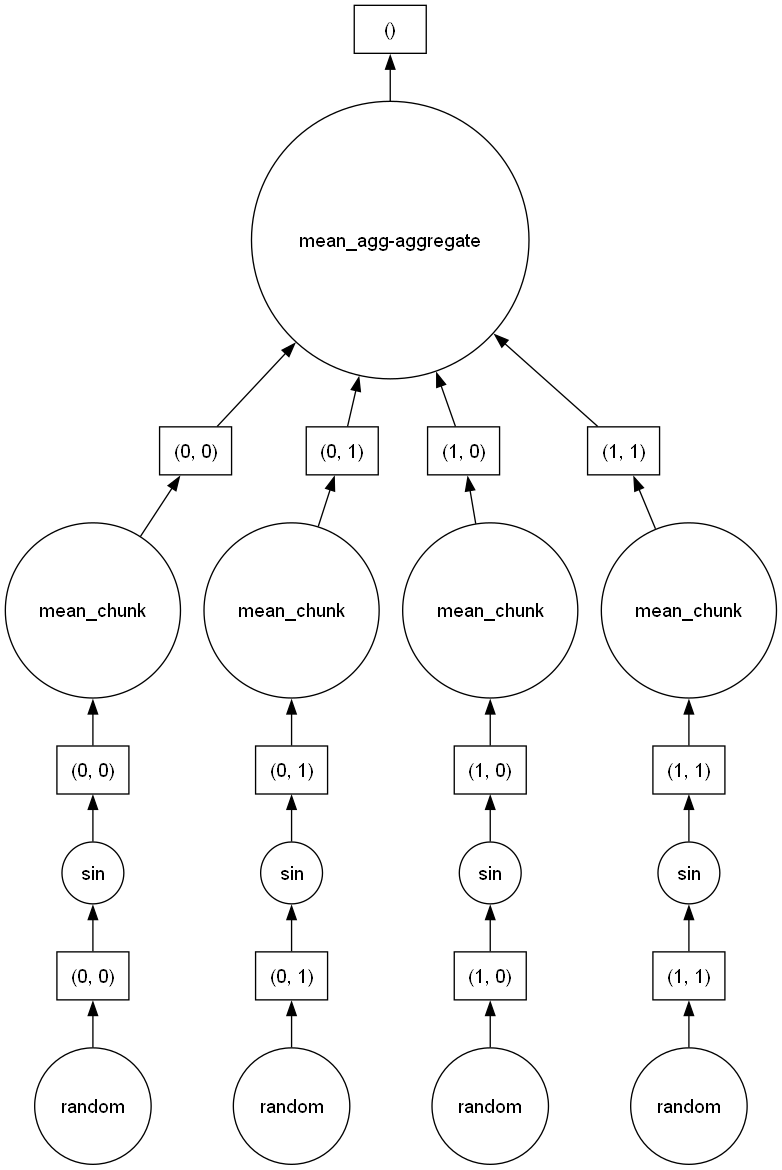

In [4]:
# Now, let's look at the Graph

mean.visualize()

As we see, the graph is representing the execution plan, in which we have 4 chunks of random values from our array, each chunk is then passed to calculate the sin for each value, the mean is calculated for each chunk and finally means are aggregated to return the final result.

Now that we have our plan, we can execute it through the *.compute()* method. 

In [5]:
mean.compute()

0.36171387835735147

## Custom Delayed Plans

Dask possesses the flexibility of allowing us to define our own *lazy algorithm* by making use of the [delayed](https://docs.dask.org/en/stable/delayed.html) interface. This is mostly helpful for cases in which parallelization is achievable, but the structure of our data cannot be abstracted as an array or dataframe. The following example taken from the official documentation exemplifies a case clearly:

In [6]:
# Suppose we have the following functions and loop:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
total

21

The previous code was eagerly executed. However, there was certainly room for an execution plan that could parallelize the tasks. For example, instead of actually looping through the elements of the list and performing the computations sequentially, a plan could take each element of the list and perform both the addition and the doubling for all elements in parallel, before adding the pairs and finally summing up all of the values.

This is achievable through the *delayed* interface:

In [7]:
output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total_delayed = dask.delayed(sum)(output)

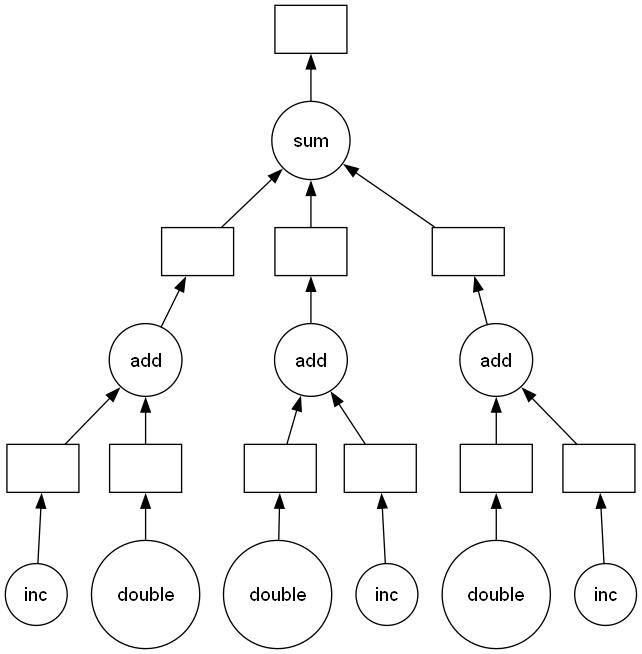

In [8]:
# Let's visualize our graph
total_delayed.visualize()

Now the initial code is represented as a graph. We can now perform the computation:

In [9]:
total_delayed.compute()

21

We can also pre-define our functions to be executed lazily through the *@delayed* decorator:

In [10]:
@dask.delayed
def inc_del(x):
    return x + 1

@dask.delayed
def double_del(x):
    return x * 2

@dask.delayed
def add_del(x, y):
    return x + y

output = []
for x in data:
    a = inc_del(x)
    b = double_del(x)
    c = add_del(a, b)
    output.append(c)

total_dec = dask.delayed(sum)(output)

In [11]:
total_dec.compute()

21

## The Dask DataFrame

The main object to work with a dataset through Dask is the [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html), which is essentially a collection of multiple Pandas DataFrames parallelized across the cluster. 

To begin our exploratory data analysis, we'll start by loading the data and creating our dataframe. For this courselet, we are using taxi trips reported to the City of Chicago in 2020. This data is publicly available through the [Chicago Data Portal](https://data.cityofchicago.org/en/Transportation/Taxi-Trips-2020/r2u4-wwk3/about_data). 

For this example, we are using the data available in the [Parquet format](https://parquet.apache.org/) This open-source format offers efficient data storage and compression, as well as better data retrieval than traditional CSV. Therefore, if the data is available in this format, we can must always take advantage of it.

In [12]:
# Loading the df
import dask.dataframe as dd

ddf = dd.read_parquet("data/chicago-taxi-2020.parquet", assume_missing=True)
ddf.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,16c7456d99031528c238bd02f40df5ab9bdf9778,88d3be8c1334607f62a8c058f680dd7fbb57826ec7408d...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,60.0,0.00,NaN,NaN,NaN,NaN,...,9.0,12.27,Credit Card,Top Cab Affiliation,NaN,NaN,<NA>,NaN,NaN,<NA>
1,472eef1d5c7a5e5ee033f673942f367dc71869f1,199fa05b63204aa1c620c161c5cebe43b0909b1ee99864...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1740.0,0.00,NaN,NaN,NaN,43.0,...,0.0,13.00,Cash,Blue Ribbon Taxi Association Inc.,NaN,NaN,<NA>,41.761578,-87.572782,POINT (-87.5727819867 41.7615779081)
2,031a4d882fb3315a490d0b5c358c945ad9b9856d,aabecb47e958f99860a3b4d01f14d53644ac26126d9519...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.70,NaN,NaN,8.0,8.0,...,5.0,14.80,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,3c416c246829dfb3f78cc93cbc7dfecdd379be15,ba106251fbb2b52177138ccbb8a1327a83c89470c240b2...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.80,NaN,NaN,8.0,8.0,...,2.0,9.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
4,3c0a22971ae070ce35e0c03f1b8e92fe7aa840cd,1f1970d8e52c7e2575aeb68eb3b6ab0e21c77b728267df...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,556.0,0.77,NaN,NaN,8.0,8.0,...,0.0,6.75,Cash,Sun Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


We will now start performing some descriptive analysis.

In [13]:
# Counting non-empty rows per column
non_empty_count = ddf.count()
non_empty_count

Dask Series Structure:
npartitions=1
Company       int64
Trip Total      ...
dtype: int64
Dask Name: to_pyarrow_string, 4 graph layers

Why cannot we see the results? As we stated at the beginning, Dask will not perform any computation until explicitly calling the *.compute()* method.

In [14]:
# Now we will get the actual result
non_empty_count.compute()

Trip ID                       3889032
Taxi ID                       3888831
Trip Start Timestamp          3889032
Trip End Timestamp            3888458
Trip Seconds                  3887483
Trip Miles                    3889002
Pickup Census Tract           1782907
Dropoff Census Tract          1770434
Pickup Community Area         3610116
Dropoff Community Area        3520203
Fare                          3888700
Tips                          3888700
Tolls                         3888700
Extras                        3888700
Trip Total                    3888700
Payment Type                  3889032
Company                       3889032
Pickup Centroid Latitude      3610818
Pickup Centroid Longitude     3610818
Pickup Centroid Location      3610818
Dropoff Centroid Latitude     3526913
Dropoff Centroid Longitude    3526913
Dropoff Centroid  Location    3526913
dtype: int64

In [15]:
# Missingness rate per column
ddf.isnull().mean().compute()

Trip ID                       0.000000
Taxi ID                       0.000052
Trip Start Timestamp          0.000000
Trip End Timestamp            0.000148
Trip Seconds                  0.000398
Trip Miles                    0.000008
Pickup Census Tract           0.541555
Dropoff Census Tract          0.544762
Pickup Community Area         0.071719
Dropoff Community Area        0.094838
Fare                          0.000085
Tips                          0.000085
Tolls                         0.000085
Extras                        0.000085
Trip Total                    0.000085
Payment Type                  0.000000
Company                       0.000000
Pickup Centroid Latitude      0.071538
Pickup Centroid Longitude     0.071538
Pickup Centroid Location      0.071538
Dropoff Centroid Latitude     0.093113
Dropoff Centroid Longitude    0.093113
Dropoff Centroid  Location    0.093113
dtype: float64

In [16]:
# Showing the top 10 rows of 2 columns
ddf[['Trip ID', 'Trip Total']].head(10)

,Trip ID,Trip Total
0,16c7456d99031528c238bd02f40df5ab9bdf9778,12.27
1,472eef1d5c7a5e5ee033f673942f367dc71869f1,13.00
2,031a4d882fb3315a490d0b5c358c945ad9b9856d,14.80
3,3c416c246829dfb3f78cc93cbc7dfecdd379be15,9.75
4,3c0a22971ae070ce35e0c03f1b8e92fe7aa840cd,6.75
5,451beabd5dd8ffc54d15166df3888fd660279a20,12.25
6,60da9b02b3297dc58d71678b512e8c0def49bccb,21.60
7,64bd098989d7ad38a071ae979c42a5603d8178e6,12.00
8,8e2fa4ad2d00c7372e5b77a3daa0ff2ac22bad1b,25.25
9,9323dfcf3aa6b0e8c571426d3937a734464f8ba0,7.75


In [17]:
# Mean of a column
ddf['Trip Total'].mean().compute()

18.36848553758326

In [18]:
# Max value of a column
ddf['Trip Total'].max().compute()

9955.55

## Visualizing Data

Given that Dask is a completely pythonic framework, data visualization is supported through popular libraries such as matplotlib and seaborn. Let's do a quick visualization example:

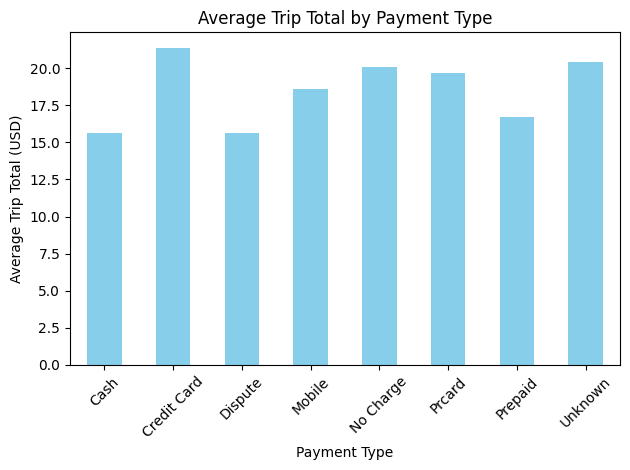

In [19]:
import matplotlib.pyplot as plt

# Let's say we want to visualize the avg trip total cost by payment type
viz_ddf = ddf.dropna(subset=['Trip Total', 'Payment Type']) # We subset the data
avg_trip_total_by_payment_type = viz_ddf.groupby('Payment Type')['Trip Total'].mean().compute() # We create a small pd.df with the information grouped

# Now we visualize as we would normally do
avg_trip_total_by_payment_type.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Type')
plt.ylabel('Average Trip Total (USD)')
plt.title('Average Trip Total by Payment Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

More on data visualization can be found in the [FOUNT Courselets library](https://voices.uchicago.edu/fount/resources/fount-courselets/).

## Improving Dataframes performance

When working with dataframes, Dask suggests a series of techniques that can help us improve the performance. Let's take a look at some of them.

**Repartition** 

When we load a dataframe, Dask will evaluate the resources, datasize and type and choose an n number to partition and distribute our dataframe. However, this n number of partitions might not be the most optimal, and so, we can perform a repartition to our data to potentially improve performance. 

In [20]:
# First, let's take a look at the current number of partitions
ddf.npartitions

1

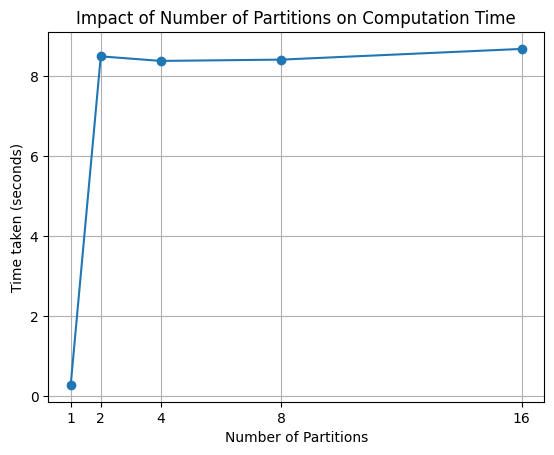

The optimal number of partitions is 1 with a time of 0.28196096420288086 seconds


In [21]:
import time

def measure_time(file_path, num_partitions):
    ddf = dd.read_parquet(file_path, assume_missing=True)
    ddf = ddf.repartition(npartitions=num_partitions)
    
    # Measure computation time
    start_time = time.time()
    result = ddf['Trip Total'].mean().compute()
    end_time = time.time()
    
    return end_time - start_time

file_path = "data/chicago-taxi-2020.parquet"

# Different numbers of partitions to test
num_partitions_list = [1, 2, 4, 8, 16]

times = []
for num_partitions in num_partitions_list:
    time_taken = measure_time(file_path, num_partitions)
    times.append(time_taken)

# Plotting the results
plt.plot(num_partitions_list, times, marker='o')
plt.xlabel('Number of Partitions')
plt.ylabel('Time taken (seconds)')
plt.title('Impact of Number of Partitions on Computation Time')
plt.xticks(num_partitions_list)
plt.grid(True)
plt.show()

# Identify the Number of Partitions with the Lowest Time
min_time = min(times)
optimal_num_partitions = num_partitions_list[times.index(min_time)]
print(f"The optimal number of partitions is {optimal_num_partitions} with a time of {min_time} seconds")

**Indexing a column**

Indexing our dataframe by a column through the use of the [*.set_index()*](https://docs.dask.org/en/latest/generated/dask.dataframe.DataFrame.set_index.html) method can help us perform faster and more efficient queries. In this case, we can make take advantage of one of the two timestamps and create an index from it. This would be smart strategy as this data is very likely to be queried constantly incorporating temporality conditions.

In [22]:
# We start by generating a new column in time format. We make this choice instead of overwriting the original column
ddf['timestamp_index'] = dd.to_datetime(ddf['Trip Start Timestamp']) 

# Now we make index our ddf using the new column
ddf = ddf.set_index('timestamp_index', sorted=True)

In [23]:
# Now, we can use our new index to subset our data
january_ddf = ddf.loc['2020-01'] # This operation is much faster through an index than without it

january_ddf.head(10)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
timestamp_index,,,,,,,,,,,,,,,,,,,,,
2020-01-01,16c7456d99031528c238bd02f40df5ab9bdf9778,88d3be8c1334607f62a8c058f680dd7fbb57826ec7408d...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,60.0,0.00,NaN,NaN,NaN,NaN,...,9.0,12.27,Credit Card,Top Cab Affiliation,NaN,NaN,<NA>,NaN,NaN,<NA>
2020-01-01,472eef1d5c7a5e5ee033f673942f367dc71869f1,199fa05b63204aa1c620c161c5cebe43b0909b1ee99864...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1740.0,0.00,NaN,NaN,NaN,43.0,...,0.0,13.00,Cash,Blue Ribbon Taxi Association Inc.,NaN,NaN,<NA>,41.761578,-87.572782,POINT (-87.5727819867 41.7615779081)
2020-01-01,031a4d882fb3315a490d0b5c358c945ad9b9856d,aabecb47e958f99860a3b4d01f14d53644ac26126d9519...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.70,NaN,NaN,8.0,8.0,...,5.0,14.80,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2020-01-01,3c416c246829dfb3f78cc93cbc7dfecdd379be15,ba106251fbb2b52177138ccbb8a1327a83c89470c240b2...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.80,NaN,NaN,8.0,8.0,...,2.0,9.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2020-01-01,3c0a22971ae070ce35e0c03f1b8e92fe7aa840cd,1f1970d8e52c7e2575aeb68eb3b6ab0e21c77b728267df...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,556.0,0.77,NaN,NaN,8.0,8.0,...,0.0,6.75,Cash,Sun Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2020-01-01,451beabd5dd8ffc54d15166df3888fd660279a20,a572ffd405aa83dbb69bede971599929a94ec9bd59aff4...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,960.0,2.40,NaN,NaN,8.0,8.0,...,1.0,12.25,Credit Card,Medallion Leasin,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2020-01-01,60da9b02b3297dc58d71678b512e8c0def49bccb,155ffe17bc32e7c3bfdfdba2750e82c6a23dab24f77d6c...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1861.0,3.16,NaN,NaN,8.0,32.0,...,1.5,21.60,Credit Card,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
2020-01-01,64bd098989d7ad38a071ae979c42a5603d8178e6,e2d8418fcdb061eee0a4318fba0a6a1200aaff0143feb0...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1723.0,0.70,NaN,NaN,8.0,8.0,...,0.0,12.00,Cash,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2020-01-01,8e2fa4ad2d00c7372e5b77a3daa0ff2ac22bad1b,249ef6f75a49feebb50f4bc68cf7ba703c4006498c63b6...,01/01/2020 12:00:00 AM,01/01/2020 01:00:00 AM,3745.0,1.64,NaN,NaN,8.0,32.0,...,0.0,25.25,Cash,Chicago Carriage Cab Corp,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)


**Persisting Data**

Another useful technique to improve our performance is to persist in memory the recurrently used data. By doing this, we avoid the constant recomputation of the dataset, and our queries are executed atop of a persisted object, optimizing performance. According to Dask documentaion, the following would be a smart workflow:

1. Load the data
2. Filter (if needed) the data to a particular subset
3. Set a smart index
4. Persist the data in memory with the use of the *client.persist* method.

We can do a example of this workflow by using the examples we have shown previously:

In [24]:
# 1. Data Loading
ddf = dd.read_parquet("data/chicago-taxi-2020.parquet", assume_missing=True) 

# 2. Filtering - Let's say we only want to analyze the trips that were payed with Cash
cash_ddf = ddf[ddf["Payment Type"] == "Cash"]

# 3. Indexing - We use our previous timestamp example
cash_ddf['timestamp_index'] = dd.to_datetime(cash_ddf['Trip Start Timestamp']) 
cash_ddf = cash_ddf.set_index('timestamp_index', sorted=True)

# 4. Persisting data
cash_ddf = client.persist(cash_ddf)

In [25]:
# Now we can perform operations which should be faster
cash_ddf['Trip Total'].mean().compute()

15.629272194689412

This section has been developed by following [official documentation on Best Practices](https://docs.dask.org/en/stable/dataframe-best-practices.html#).

## Bags

The final type of Dask object that we are going to explore are [Dask Bags](https://docs.dask.org/en/stable/bag.html) Dask Bags are a special type of object that allows us to perform parallelized operations on Python objects that do not follow the structure of a Pandas Dataframe nor Numpy Array. Bags are particullarly useful when working with unstructured data like JSON files. Lets look at a example.

In [26]:
# Imagine that we had a json file that looked like the following unstructured data, representing a series of social media posts

posts = [
    {"id": 1, "text": "Love using #dask for data processing!", "tags": ["data", "python", "dask"], "user": {"id": 100, "name": "John"}},
    {"id": 2, "text": "Exploring the #python ecosystem is fascinating. #datascience", "user": {"id": 101, "name": "Jane"}},
    {"id": 3, "text": "Check out my latest #blog on #machinelearning.", "tags": ["AI", "blog", "machinelearning"], "user": {"id": 102, "name": "Jack"}},
    # Some posts might not have hashtags or are missing other fields
    {"id": 4, "text": "Just another day training a #machinelearning model with #dask.", "user": {"id": 103, "name": "Jill"}}
]


As you can observe, the *posts* data is not structured, as some posts come with tags and some other don't. Imagine an scenario in which we wanted to analyze thousands of posts from a social media site. We would certainly like to take advantage of parallelization to do this process. This is where Dask Bags can help us. Suppose that we wanted to count the frequency of hashtags among posts. The following code performs that operation by transforming our posts data into a bag:

In [27]:
import dask.bag as db
import re

posts_bag = db.from_sequence(posts)

# Function to extract hashtags from text
def extract_hashtags(post):
    hashtags = re.findall(r"#(\w+)", post["text"])
    return hashtags

# Function to filter posts with text field
def filter_posts_with_text(post):
    return "text" in post

# Apply filter and map functions, then flatten the list of lists
hashtags = posts_bag.filter(filter_posts_with_text).map(extract_hashtags).flatten()

# Count occurrences of each hashtag
hashtag_counts = hashtags.frequencies().compute()

hashtag_counts


[('dask', 2),
 ('python', 1),
 ('datascience', 1),
 ('blog', 1),
 ('machinelearning', 2)]

## Hands-On

Now it is time to apply some of the learned contents. 